<a href="https://colab.research.google.com/github/Ricardoc851/MonkeyClassifier/blob/master/Fastmonkey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#We want to delete the current Pytorch and reinstall torch ==1.4.0

In [0]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 31.3MB/s 


##import FastAI

In [0]:
import fastai
from fastai.vision import *

## Set up Kaggle

In [0]:
! pip install -q kaggle
! mkdir ~/.kaggle

## Put your Json file into files then run the following block

In [0]:
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#We will be using the 10-monkey-species dataset

In [0]:
! kaggle datasets download -d slothkong/10-monkey-species

 97% 529M/547M [00:09<00:00, 42.8MB/s]
100% 547M/547M [00:10<00:00, 57.0MB/s]


## We want to unzip the data

In [0]:
!unzip 10-monkey-species.zip

## We load the data from folder, we use test as our validation given that val only contains 16 images, and test contains 624

### We also transform it into a 128 x 128, and select a batch size of 32, also apply some transfomations for data augmentation and normalize the data with parameters used for the image_net dataset


In [0]:
data = ImageDataBunch.from_folder(path = '/content/', train = 'training', 
                                  valid = 'validation', 
                                  size=128,bs=32, ds_tfms=get_transforms()).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (1097 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n3,n3,n3,n3,n3
Path: /content;

Valid: LabelList (272 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n3,n3,n3,n3,n3
Path: /content;

Test: None

## Proceed to create a label_dict, to just for us to display the images later

In [0]:
label_dict = dict()
for key, val in data.label_list.train.y.c2i.items():
  label_dict[val] = key

label_dict

{0: 'n0',
 1: 'n1',
 2: 'n2',
 3: 'n3',
 4: 'n4',
 5: 'n5',
 6: 'n6',
 7: 'n7',
 8: 'n8',
 9: 'n9'}

## FastAi has this .show_batch() which lets you explore the internals of your data

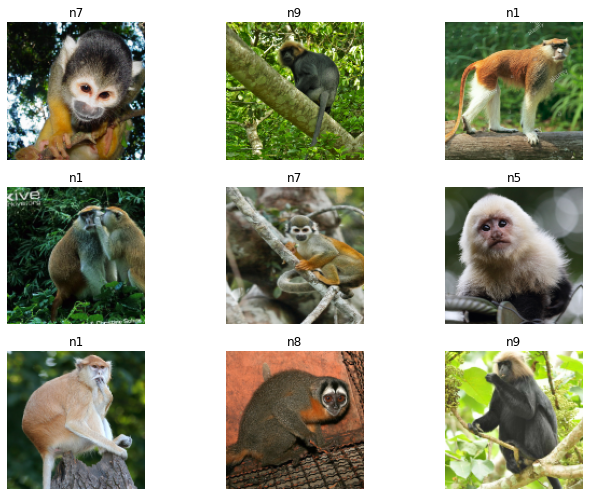

In [0]:
data.show_batch(3, figsize=(10,7));

#We try to load the learner first, if available, otherwise we can just create a new one.

### This model will be using Vgg16_bn, but you can try other popular pretrained networks such densenet121

### We also make use of AUROC score, since accuracy is not necessarily a good metric, AUROC takes into account false positives and true positives for score calculation

In [0]:
try:
  
  
  learn = load_learner(path = '/content/', file = 'dense')
  learn.data = data
  print("dense model imported")
except:
  learn = cnn_learner(data, models.vgg19_bn, 
                   metrics=[accuracy, AUROC()],
                   model_dir='/content/')
  print("created new model")

dense model imported


In [0]:
!nvidia-smi

Sun May  3 06:17:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    32W / 250W |    739MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## We first find the learning rate with the he lowest slope, meaning that this one will contain the minimum gradient.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.31E-07


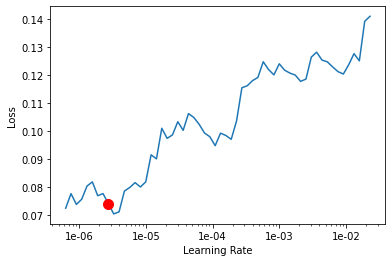

In [0]:
learn.recorder.plot(suggestion= True)

## We train for 2 cycles

In [0]:
learn.fit_one_cycle(4, 2.75E-06)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.110354,0.048428,0.985294,0.522102,00:50
1,0.102725,0.047028,0.985294,0.500878,00:50
2,0.103303,0.052400,0.981618,0.506148,00:50
3,0.104667,0.054259,0.981618,0.528103,00:49


## We save the model

### I called it dense, but feel free to use any other name

In [0]:
learn.export('/content/dense')

## Optional, you can also UNFREEZE the model, so it trains all the layers, not only the latest ones. This is useful to finetune your model

In [0]:



learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4, 1e-3))


epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.140396,0.238280,0.933824,0.650761,01:01
1,0.135651,0.167030,0.959559,0.557816,01:00


## Let's take a look at how the bad predictions look like

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

#Let's predict on single images

In [0]:
test_im1 = '/content/validation/validation/n8/n00.jpg' #should be n8
test_im2 ='/content/validation/validation/n2/n200.jpg' #should be n2

In [0]:
im = open_image(test_im2)

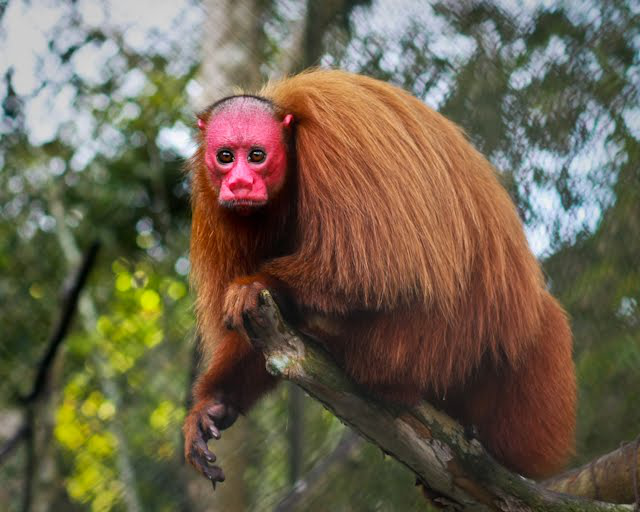

In [0]:
im

In [0]:
category, category_t, preciction = learn.predict(im)

In [0]:
category_t

tensor(2)

In [0]:
preciction

tensor([1.4120e-08, 1.2257e-08, 1.0000e+00, 9.8677e-09, 9.7772e-09, 1.7741e-11,
        4.1677e-09, 2.3296e-10, 4.4248e-09, 6.8939e-10])

## Lets make our prediction

In [0]:
def plot_class_pred(learner, im_path, label_dict):
    im = open_image(im_path)
    category, category_t, preds = learner.predict(im)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(1)
    plt.imshow(im.data.detach().numpy().transpose(1, 2, 0))
    plt.gca().set_title('{0}, {1:.1f}%'.format(
        label_dict[int(category_t)],
        preds[int(category_t)].detach().numpy() * 100),
        color=("green")
    )
    return fig

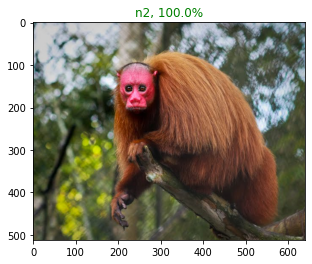

In [0]:
fig = plot_class_pred(learn, test_im2, label_dict)

## Why do this? Because you can save this for later purposes, like a presentation, or website

In [0]:
fig.savefig('prediction.png')